# μ-scaled SOC Projection with Backward Euler (explicit w = r(y) − ρk ũ)

This notebook demonstrates how to use `MuScaledSOCProjection` with Backward Euler.
We explicitly construct the tangential variable via a user-provided `prefill_func`
that sets `w = r(y) − ρk · ũ` before projecting the block (s, w) onto the cone
`K_μ = { (s, w) : s ≥ 0, ||w|| ≤ μ s }`. A `blocks_func` provides the block structure
each iteration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Solve_IVP_NS.projections import MuScaledSOCProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import BackwardEuler
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver

## Define dynamics and explicit mapping with u = v

We use the state ordering y = [v_x, v_y, q_x, q_y, p_x, p_y] with p_x,p_y as the constrained (tangential) components.
We build u = v and form the modified velocity

ũ = u + [e u_x^{prev} + μ |u_y|; 0]

and set z[w] = r − ρk · ũ on the w-indices (w ≡ [p_x, p_y]) before projecting onto the μ-scaled SOC.
All other components pass through unchanged (identity projection of ȳ = y − ρk F(y)).

In [2]:
import numpy as np

# State: y = [v_x, v_y, q_x, q_y, p_x, p_y]
# Constrained indices are p_x,p_y only; others are identity-projected.

mass = 1.0
K = 1.0 * np.eye(2)    # stiffness on q (s)
E = 0.5 * np.eye(2)*0     # damping on v

# Mass/descriptor matrix A matching [v(2), q(2), p(2)] ordering
I2 = np.eye(2)
Z2 = np.zeros((2, 2))
A = np.block([
    [mass * I2,  Z2,      Z2],
    [Z2,         I2,      Z2],
    [Z2,         Z2,      Z2],
])

g_vec = np.array([0.0, 10.0])

def rhs(t, y):
    # y: [v_x, v_y, q_x, q_y, p_x, p_y]
    v = y[0:2]
    q = y[2:4]
    p = y[4:6]
    v_dot = - K @ q - E @ v - mass * g_vec
    q_dot = v
    p_dot = np.zeros_like(p)
    return np.concatenate([v_dot, q_dot, p_dot])


def mu_func(y, t=None, Fk_val=None):
    # Single μ for the (virtual s, p) block
    return 0.5


def phi_fun(y, prev_state, t):
    # u = v, and ũ = u + [e u_x^{prev} + μ |u_y|; 0]
    v = y[0:2]
    v_prev = prev_state[0:2] 
    mu_val = float(mu_func(y, t))
    e = 0.5  # restitution-like coefficient; adjust as needed
    tilde_T = v[0]
    tilde_N = v[1] + e * v_prev[1] + mu_val * abs(v[0])
    return np.array([tilde_T, tilde_N])
    # return np.array([v[0] + e * v_prev[0] + mu_val * abs(v[1]), v[1]])

    # return np.array([v[0] + e * v_prev[0] + mu_val * abs(v[1]), v[1]])


def prefill_func(t, candidate, current_state, prev_state, Fk_val, rhok=None):
    # Build z working copy; set only w-indices: z[w] = r − ρk · ũ, where u = v
    z = candidate.copy()
    y = current_state
    # print('state')
    u_tilde = phi_fun(y, prev_state, t)
    # Effective rho per call; if solver passes scalar rhok, use it; otherwise default 1
    rho_eff = 1.0 if rhok is None else (float(rhok) if np.isscalar(rhok) else 1.0)

    # Use candidate (r) on w-indices for r − ρk ũ
    return u_tilde - rho_eff * Fk_val[:2]
# def prefill_func(t, candidate, current_state, prev_state, Fk_val, rhok=None):
#     # Build z working copy; set only w-indices: z[w] = r − ρk · ũ, where u = v
#     z = candidate.copy()
#     y = current_state
#     # print('state')
#     u_tilde = phi_fun(y, prev_state, t)
#     # Effective rho per call; if solver passes scalar rhok, use it; otherwise default 1
#     rho_eff = 1.0 if rhok is None else (float(rhok) if np.isscalar(rhok) else 1.0)

#     # Use candidate (r) on w-indices for r − ρk ũ
#     return Fk_val[4:6] - rho_eff * u_tilde



## Build projector, solver, and Backward Euler integrator
We use a projected fixed-point (VI) nonlinear solve per implicit step.

In [10]:
from Solve_IVP_NS.projections import MuScaledSOCProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import BackwardEuler
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver

# Component slices for VI solver: [v(2), q(2), p(2)]
component_slices = [slice(0,2), slice(2,4), slice(4,6)]


proj = MuScaledSOCProjection(
    get_mu=mu_func,
    constraint_indices=[0,1],      # only p_x,p_y are constrained
    prefill_func=prefill_func,    # sets z[w] = r − ρk · ũ with u = v
    component_slices=component_slices,
)

solver = ImplicitEquationSolver(
    method='VI',
    proj=proj,
    tol=1e-8,
    max_iter=100,
    component_slices=component_slices,
    # vi_strict_block_lipschitz=False
)


integrator = BackwardEuler(solver=solver, A=A)

t0, tf = 0.0, 1.0
y0 = np.array([1.0, 1.0e-2*0,   # v_x, v_y
               0.0, 1.0,   # q_x, q_y (small)
               0.0, 0.0])  # p_x, p_y

system = ODESystem(fun=rhs, y0=y0, method=integrator, adaptive=True)
driver = ODESolver(system, t_span=(t0, tf), h=0.002)
t, y_hist, h_hist, fk_hist, info = driver.solve()



gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 0.9978084246103257
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 1.0
gap: 0.9997255418746751
gap: 0.9999018642509708
gap: 0.9997255418746751
gap: 0.9997255418746751
gap: 0.9997255418746751
gap: 0.9997255418746751
gap: 0.9999018642509708
gap: 0.9999465334108804
gap: 0.9999018642509708
gap: 0.9999018642509708
gap: 0.9999018642509708
gap: 0.9999018642509708
gap: 0.9999465334108804
gap: 0.999954531462963
gap: 0.9999465334108804
gap: 0.9999465334108804
gap: 0.9999465334108804
gap: 0.9999465334108804
gap: 0.999954531462963
gap: 0.9999557867274445
gap: 0.999954531462963
gap: 0.999954531462963
gap: 0.999954531462963
gap: 0.999954531462963
gap: 0.9999557867274445
gap: 0.999955970409412

## Check the SOC condition and plot
We expect `||w|| <= μ s` after projection at each accepted step.

Final y: [ 9.09090916e-01 -4.52536291e+00  4.11396654e-01  2.86802991e-08
  0.00000000e+00  0.00000000e+00]
Final ||w||: 0.0    mu*s: 0.0
Feasible?  True


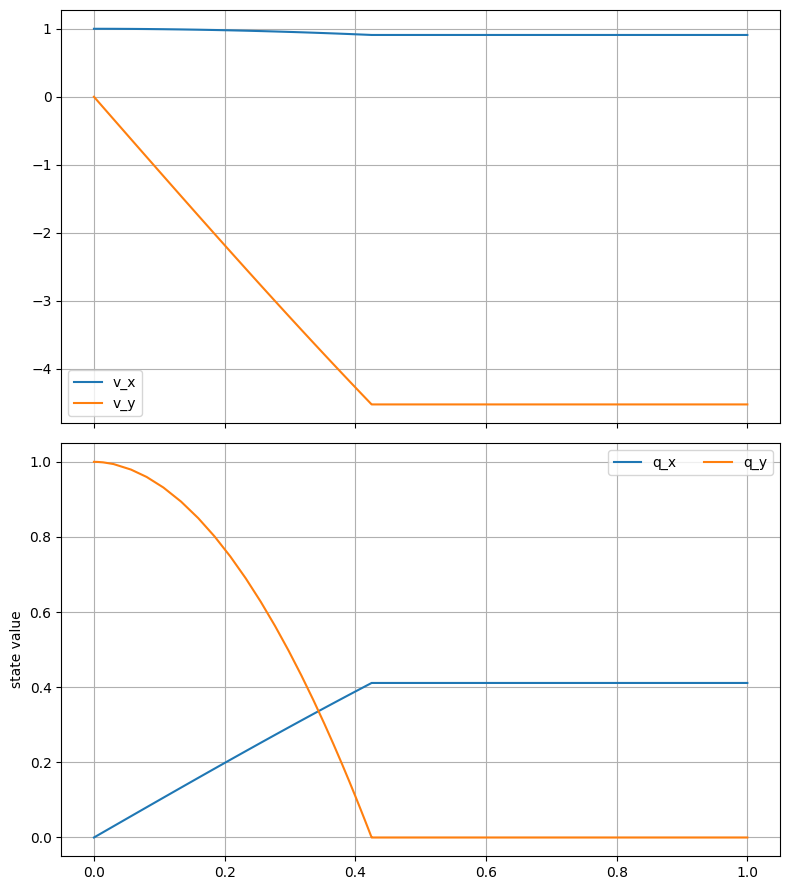

In [9]:
s_norm = np.linalg.norm(y_hist[:, 0:2], axis=1)  # s is virtual = ||v||
w = y_hist[:, 4:6]
w_norm = np.linalg.norm(w, axis=1)
mu = 0.0

print('Final y:', y_hist[-1])
print('Final ||w||:', float(w_norm[-1]), '   mu*s:', float(mu * s_norm[-1]))
print('Feasible? ', bool(w_norm[-1] <= mu * s_norm[-1] + 1e-12))

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(8, 9), sharex=True)

# Panel 1: SOC feasibility
axs[0].plot(t, y_hist[:, 0], label='v_x')
axs[0].plot(t, y_hist[:, 1], label='v_y')
axs[0].legend()
axs[0].grid(True)

# Panel 2: individual state components

axs[1].plot(t, y_hist[:, 2], label='q_x')
axs[1].plot(t, y_hist[:, 3], label='q_y')
# axs[1].plot(t, y_hist[:, 4], label='p_x')
# axs[1].plot(t, y_hist[:, 5], label='p_y')
axs[1].set_ylabel('state value')
axs[1].legend(loc='best', ncols=3)
axs[1].grid(True)


plt.tight_layout()
plt.show()

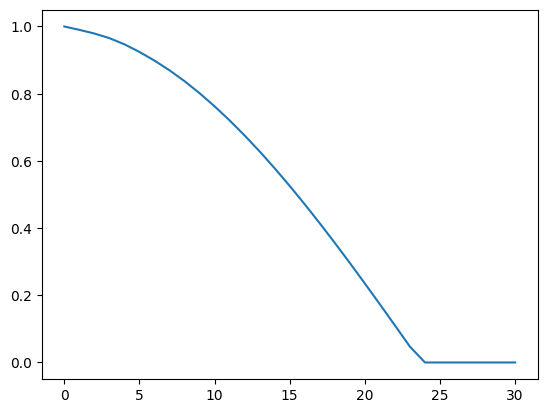

In [5]:
plt.plot(y_hist[:,0])